# Import


In [1]:
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import numpy as np

In [2]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0] for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

In [3]:
lines_train = Path("snips-data/train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist',
 'put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist',
 'add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist',
 'add:O this:O artist:B-music_item to:O my:B-playlist_owner this:B-playlist is:I-playlist miguel:I-playlist bosé:I-playlist playlist:O <=> AddToPlaylist',
 'add:O heresy:B-entity_name and:I-entity_name the:I-entity_name hotel:I-entity_name choir:I-entity_name to:O the:O evening:B-playlist acoustic:I-playlist playlist:O <=> AddToPlaylist']

- Intent is at the end of line, separated with <=>
- Word tagged with **O** means outside of entity
- Word tagged with **B** means begining of an entity
- **I** mean inside an entity

In [4]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'word_labels': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

In [5]:
lines_train[0]

'Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist'

In [6]:
parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train.head()

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11


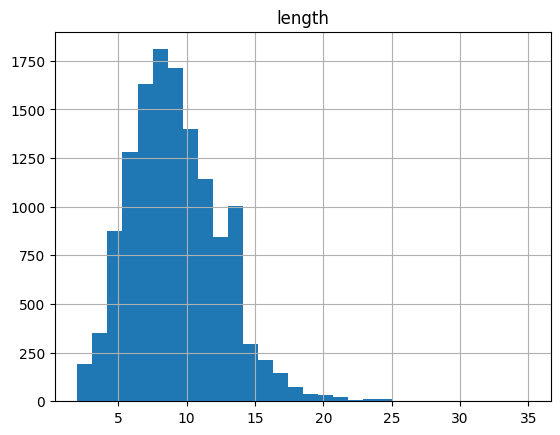

In [7]:
df_train.hist("length", bins=30);

## Tokenize with Bertokiner from HuggingFace

In [8]:
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [9]:
lines_valid = Path("snips-data/valid").read_text("utf-8").strip().splitlines()
lines_test = Path("snips-data/test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])

In [10]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'Add Don and Sherri to my Meditate to Sounds of Nature playlist'

In [11]:
tokenizer.tokenize(first_sentence)

['Ad',
 '##d',
 'Don',
 'and',
 'She',
 '##rri',
 'to',
 'my',
 'Me',
 '##dit',
 '##ate',
 'to',
 'Sounds',
 'of',
 'Nature',
 'play',
 '##list']

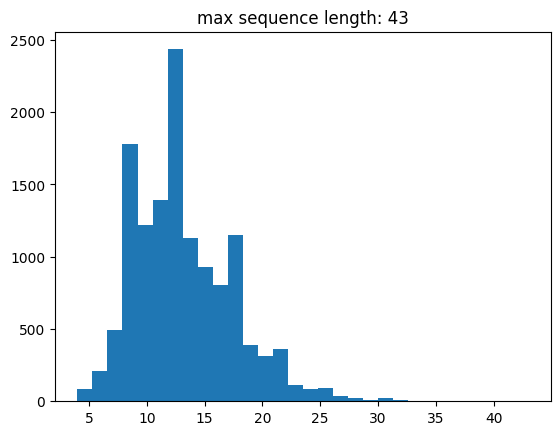

In [12]:
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

In [13]:
def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids":torch.from_numpy(token_ids), 
            "attention_mask": torch.from_numpy(attention_masks)}

In [14]:
encoded_train = encode_dataset(tokenizer, df_train["words"], 45)
encoded_train["input_ids"]

tensor([[  101, 24930,  1181,  ...,     0,     0,     0],
        [  101,  1508,  1244,  ...,     0,     0,     0],
        [  101,  5194,  1103,  ...,     0,     0,     0],
        ...,
        [  101, 27640,  1116,  ...,     0,     0,     0],
        [  101,  5979,  6608,  ...,     0,     0,     0],
        [  101,  1327,  2523,  ...,     0,     0,     0]], dtype=torch.int32)

In [15]:
encoded_train["input_ids"].shape

torch.Size([13084, 45])

In [16]:
encoded_train["attention_mask"].shape

torch.Size([13084, 45])

In [17]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 45)
encoded_test = encode_dataset(tokenizer, df_test["words"], 45)

## Encoding the Sequence Classification Targets

In [18]:
intent_names = Path("snips-data/vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [19]:
intent_train = df_train["intent_label"].map(intent_map).values

In [20]:
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

In [21]:
import torch.nn as nn
from transformers import AutoModel

class IntentClassificationModel(nn.Module):
    
    def __init__(self, intent_num_labels=None, model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, intent_num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = self.dropout(outputs.pooler_output)

        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits

In [22]:
base_bert_model = AutoModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = correct = 0
    for x, mask, y in loader:
      x = x.to(device)
      y = y.to(device)
      mask = mask.to(device)
      with torch.no_grad():
        y_scores = model(x, mask)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred == y).item()
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct / num

In [25]:
from torch.utils.data import TensorDataset, DataLoader
train_encoded_dataset = TensorDataset(encoded_train["input_ids"],
                                      encoded_train["attention_mask"], torch.from_numpy(intent_train))

In [26]:
batch_size = 2
maxlen = 20
hidden_size = 128
embed_size = 128
device = torch.device('cuda')
train_loader = DataLoader(train_encoded_dataset,batch_size=batch_size, shuffle=True)

In [27]:
valid_encoded_dataset = TensorDataset(encoded_valid["input_ids"], 
                                      encoded_valid["attention_mask"],
                                      torch.from_numpy(intent_valid))
test_encoded_dataset = TensorDataset(encoded_test["input_ids"], 
                                      encoded_test["attention_mask"],
                                      torch.from_numpy(intent_test))
valid_loader = DataLoader(valid_encoded_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_encoded_dataset,batch_size=batch_size, shuffle=True)

In [28]:
import torch.optim as optim

def fit(model, epochs, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, mask, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            mask = mask.to(device)
            optimizer.zero_grad()
            y_scores = model(x, mask)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, valid_loader))

In [29]:
intent_model= intent_model.to(device)

In [30]:
torch.cuda.empty_cache()
#fit(intent_model, 5, lr=2e-5)

In [31]:
print('BERT', *perf(intent_model, test_loader))

BERT 1.0087824155603136 0.12857142857142856


In [32]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

In [33]:
class RNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.decision = nn.Linear(1 * 2 * hidden_size, len(label_vocab))
    self.to(device)
  
  def forward(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed) 
    drop = self.dropout(hidden.transpose(0, 1).reshape(x.shape[0], -1))
    return self.decision(drop)

#rnn_model = RNNClassifier()

In [34]:
slot_names = ["[PAD]"]
slot_names += Path("snips-data/vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)

In [35]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointIntentAndSlotFillingModel(nn.Module):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="bert-base-cased", dropout_prob=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, intent_num_labels)
        self.slot_classifier = nn.Linear(self.bert.config.hidden_size, slot_num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output

        sequence_output = self.dropout(sequence_output)
        slot_logits = self.slot_classifier(sequence_output)

        pooled_output = self.dropout(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
def joint_fit(model, dataloader, epochs, lr=1e-3):
    intent_criterion = nn.CrossEntropyLoss()
    slot_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, mask, y, slot in dataloader:
            x = x.to(device)
            y = y.to(device)
            mask = mask.to(device)
            slot = slot.long().to(device)
            #print("Slot", slot.shape)
            #print("Y", y.shape)
            optimizer.zero_grad()
            slot_scores, intent_scores = model(x, mask)
            #print("slot scores", slot_scores.shape)
            slot_loss = slot_criterion(slot_scores.view(-1, len(slot_map)),
                                        slot.view(-1))
            intent_loss = intent_criterion(intent_scores, y)
            loss = slot_loss + intent_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *joint_perf(model, slot_valid_loader))

In [37]:
def joint_perf(model, loader):
    slot_criterion = nn.CrossEntropyLoss()
    intent_criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = correct_intent = correct_slot = 0
    for x, mask, y, slot in loader:
      x = x.to(device)
      y = y.to(device)
      mask = mask.to(device)
      slot = slot.to(device)
      with torch.no_grad():
        slot_scores, intent_scores = model(x, mask)
        slot_loss = slot_criterion(slot_scores.view(-1, len(slot_map)),
                                    slot.view(-1).long())
        intent_loss = intent_criterion(intent_scores, y)
        intent_pred = torch.max(intent_scores, 1)[1]
        slot_pred = torch.argmax(slot_scores, dim=2)
        correct_slot += torch.sum(slot_pred.view(batch_size, 45) == slot).item()
        correct_intent += torch.sum(intent_pred == y).item()
        total_loss += slot_loss.item() + intent_loss.item()
        num += len(y)
    return total_loss / num, correct_intent / num, correct_slot/num

In [38]:
def joint_perf(model, loader):
    slot_criterion = nn.CrossEntropyLoss()
    intent_criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = correct_intent = correct_slot = num_slot = 0
    for x, mask, y, slot in loader:
        x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)
        slot = slot.to(device)
        batch_size, sequence_length = x.size()
        with torch.no_grad():
            slot_scores, intent_scores = model(x, mask)
            slot_loss = slot_criterion(
                slot_scores.view(-1, len(slot_map)),
                slot.view(-1).long()
            )
            intent_loss = intent_criterion(intent_scores, y)
            intent_pred = torch.max(intent_scores, 1)[1]
            #print(intent_pred.shape, y.shape)
            slot_pred = torch.argmax(slot_scores, dim=2)
            correct_slot += torch.sum(slot_pred == slot).item()
            correct_intent += torch.sum(intent_pred == y).item()
            total_loss += slot_loss.item() + intent_loss.item()
            num += len(y)
            num_slot += len(slot)
    return total_loss / num, correct_intent/ num, correct_slot/(45*num)

In [39]:
slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 45)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 45)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, 45)

In [40]:
slot_train_dataset = TensorDataset(encoded_train["input_ids"],
                                      encoded_train["attention_mask"], torch.from_numpy(intent_train),
                                      torch.from_numpy(slot_train))
slot_valid_dataset = TensorDataset(encoded_valid["input_ids"],
                                      encoded_valid["attention_mask"], torch.from_numpy(intent_valid),
                                      torch.from_numpy(slot_valid))
slot_test_dataset = TensorDataset(encoded_test["input_ids"],
                                      encoded_test["attention_mask"], torch.from_numpy(intent_test),
                                      torch.from_numpy(slot_test))

In [41]:
slot_train_loader = DataLoader(slot_train_dataset,batch_size=batch_size, shuffle=True)
slot_valid_loader = DataLoader(slot_valid_dataset,batch_size=batch_size, shuffle=True)
slot_test_loader = DataLoader(slot_test_dataset,batch_size=batch_size, shuffle=True)

In [42]:
x = next(iter(slot_train_loader))

In [43]:
x[3].shape

torch.Size([2, 45])

In [44]:
with torch.no_grad():
  x_inputs = x[0].to(device)
  mask = x[1].to(device)
  sl, intt = joint_model.to(device)(x_inputs, mask)

In [45]:
sl = sl.view(-1, 73)
sl_t = x[3].view(-1).long().to(device)
print(sl_t.shape, sl.shape)
output = nn.CrossEntropyLoss()(sl, sl_t)

torch.Size([90]) torch.Size([90, 73])


In [42]:
torch.cuda.empty_cache()
device = "cuda"
joint_fit(model=joint_model.to(device),
          dataloader=slot_train_loader,lr=2e-5, epochs=5)

0 0.8888456590260778 0.4064024568349123 0.9285714285714286 0.8860634920634921
1 0.22157918767205306 0.24991630019220923 0.9328571428571428 0.9351746031746032
2 0.1095257426957999 0.1733253741936226 0.9528571428571428 0.9697142857142858
